This example shows how the interpolator prediction compares to a simulation randomly chosen from the training set.

In [1]:
import os, sys, glob
os.environ["OMP_NUM_THREADS"] = "12"
import numpy as np
import save_sklearn_gp as ssg
from natsort import natsorted

# loading all the models from the family trained using a pole-on viewing angle

files = glob.glob('surrogate_data/2021_Wollaeger_TorusPeanutWind2/theta00deg/*')
files = natsorted(files) # sorting is necessary! otherwise time will be out of order

x_train = np.loadtxt(files[-1]+'/model_X.dat') # all files do NOT have the same X training data, but loading from the last one ensures that the previous interpolators will include that event
idx = np.random.randint(x_train.shape[0]) # randomly choose one of the events in the training set
inputs = x_train[None, idx]

# loop through all the individual time steps, making a prediction at each

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
    
	x_train = np.loadtxt(file+'/model_X.dat') # size of training set changes at later times (not all sims go out to same time)
	idx = np.argmin([np.sum(np.abs(x_train[idx, :]-inputs[0, :])) for idx in range(x_train.shape[0])]) # finds index for inputs
	sim = np.loadtxt(file+'/model_y.dat')[idx] # above line identifies new index for event due to changing size of training set
	sim *= model._y_train_std # 
	sim += model._y_train_mean

	pred, err = ssg.predict(model, inputs)
    
	try:
		lc = np.append(lc, pred)
		sim_lc = np.append(sim_lc, sim)
		errs = np.append(errs, err)
	except NameError:
		lc = pred # if first time point, initializes the light curve array
		sim_lc = sim
		errs = err # same as above, but for errors

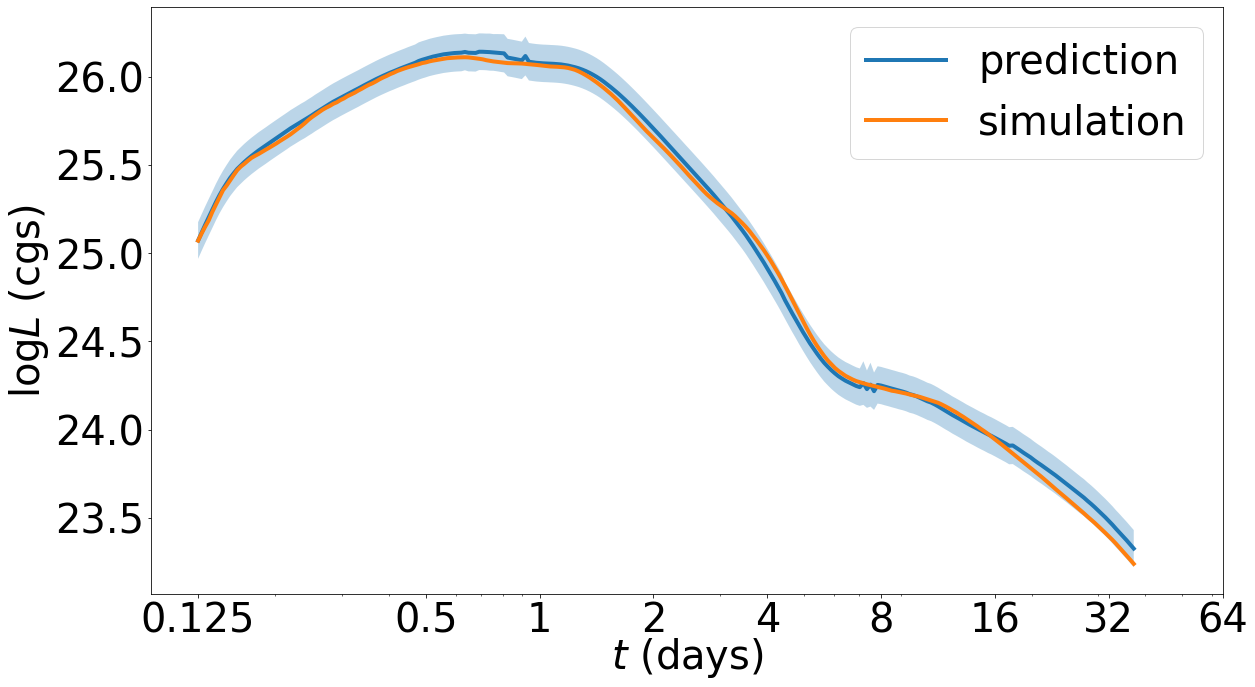

In [2]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import itertools

def flip(items, ncol):
    '''
    credit to Avaris on StackOverflow for this function
    '''
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

times = np.logspace(np.log10(0.125), np.log10(37.239195485411194), 264)

colors = {"g": "blue", "r": "cyan", "i": "lime", "z": "green", "y": "greenyellow", "J": "gold",
         "H": "orange", "K": "red", "S": "darkred"}
wavelengths = 'grizyJHKS'
plt.figure(figsize=(19.2, 10.8))
plt.rc('font', size = 40)
plt.rc('lines', lw=4)
#for band in range(lc.shape[1]):
plt.plot(times, lc, label='prediction')#, color=colors[wavelengths[band]], label=wavelengths[band])
plt.plot(times, sim_lc, label='simulation')
plt.fill_between(times, lc-errs, lc+errs, alpha=0.3)#, color=colors[wavelengths[band]], alpha=0.3)
plt.xscale('log')
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8, 16, 32, 64])
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.xlabel(r"$t$ (days)", labelpad=-5)
plt.ylabel(r"$\log L$ (cgs)")
plt.legend()
plt.savefig('pred_onsample.png')